<a href="https://colab.research.google.com/github/lukasoares/Model_to-predict_stroke/blob/main/DataStrokeWithPysparkSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Iniciando o Spark no Google Colab:

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("DataStrokeWithPysparkSQL") \
    .getOrCreate()

In [5]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importando a base de dados

In [6]:
data= spark.read.csv('/content/drive/MyDrive/base_de_dados/Stroke-data/healthcare-dataset-stroke-data.csv', header = True, inferSchema = True)

In [7]:
data.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

Como podemos ver, essa base de dados contém os tipos das colunas já categorizados de maneira apropriada, com excessão da categória "bmi". Foi feita a transformação dessa coluna para "DoubleType"

In [8]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [9]:
from pyspark.sql.types import DoubleType, StringType

In [10]:
data = data.withColumn('bmi', data['bmi'].cast(DoubleType()))
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [11]:
data.count()

5110

In [12]:
len(data.columns)

12

##Limpeza dos dados

In [13]:
from pyspark.sql import functions as f

Primeiro vamos tentar localizar os dados nulos de todas as colunas, utilizando um loop que soma 1 (ou True) se a coluna contém um dado nulo ou N/A.

In [14]:
data.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in data.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



Foram localizados 201 dados nulos na coluna "bmi". Para a subtituição dessa valores foi utilizado a mediana. Para facilitar o processo, utilizei a função toPandas() para conseguir a mediana de maneira mais fácil.

In [15]:
data = data.withColumn("bmi", f.when(f.isnull('bmi'), data.toPandas().bmi.median()).otherwise(data["bmi"]))

In [16]:
data.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

"Com a classe "createOrReplaceTempView", é possível criar uma "view" no "pyspark.sql" que permite fazer consultas utilizando a linguagem SQL."

In [17]:
data.createOrReplaceTempView("dataView")

Após uma observação mais atenciosa, foi localizado 1544 dados "Unknown" da coluna "smoking_status". Como se trata de uma "coluna" muito relevante para a nossa análise, foi escolhido a exclusão desse dados.

In [18]:
for c in ["gender", "ever_married",  "work_type", "Residence_type", "smoking_status"]:
  spark.sql(f"SELECT DISTINCT({c}) FROM dataView").show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

+------------+
|ever_married|
+------------+
|          No|
|         Yes|
+------------+

+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



In [19]:
data_modi = spark.sql('SELECT * from dataView WHERE smoking_status != "Unknown"')
data_modi.createOrReplaceTempView("dataView")

In [20]:
data_modi.createOrReplaceTempView("dataView")

In [21]:
data_modi.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

#Análise dos Dados

A primeira análise foi feita em cima da distribuição das curvas de frequênciadas variáveis quantitativas envolvidas nessa análise.

In [22]:
df = data_modi.toPandas()

Pela análise gráfica, a variável 'age' apresenta uma distribuição parecida com a normal, apesar do aumento da frequência ao chegar na faixa dos 80 anos. Já as outras duas variáveis, "avg_glucose_level" e "bmi", apresentam uma distribuição assimétrica para a direita.

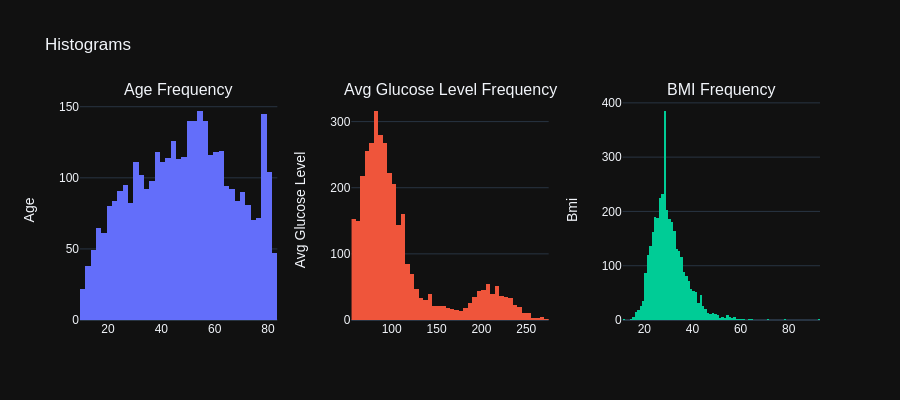

In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
column_list_numerics = ['age', 'avg_glucose_level', 'bmi']
fig = make_subplots(rows=1, cols=3, subplot_titles = ['Age Frequency', 'Avg Glucose Level Frequency', 'BMI Frequency'], horizontal_spacing=0.1)
count = 0
for i in column_list_numerics:
  count +=  1
  fig.add_trace(go.Histogram(x = df[i]),row=1, col=count).update_yaxes(title = i.title().replace('_', ' '), row=1, col=count)
fig.update_layout(title_text="Histograms", height=400, width=900, template="plotly_dark", showlegend=False)
fig.show('png')


In [26]:
len(df.columns)

12

##Análise por Gêneros da Coluna "stroke"
Inicialmente, realizou-se a análise da ocorrência de AVCs separando os indivíduos por gênero. Foram avaliados os dados das pessoas que já sofreram ataque cardíaco e os que nunca sofreram, para que fosse possível identificar possíveis diferenças entre os gêneros.

In [27]:
import pandas as pd
import plotly.express as px



In [28]:
count_stroke =spark.sql('SELECT Gender, COUNT(stroke) FROM dataView group by gender').toPandas()
count_stroke 

,Gender,count(stroke)
0,Female,2158
1,Other,1
2,Male,1407


In [29]:
stroke_gender_1 = spark.sql('SELECT Gender, COUNT(stroke) FROM dataView WHERE STROKE == 1 group by gender').toPandas()
stroke_gender_1

,Gender,count(stroke)
0,Female,116
1,Male,86


In [30]:
stroke_gender_2 = spark.sql('SELECT Gender, COUNT(stroke) FROM dataView WHERE STROKE == 0 group by gender').toPandas()
stroke_gender_2

,Gender,count(stroke)
0,Female,2042
1,Other,1
2,Male,1321


In [31]:
stroke_rate_gender =stroke_gender_1.set_index('Gender')['count(stroke)']/count_stroke.set_index('Gender')['count(stroke)'].drop(index = 'Other', axis = 0) * 100
stroke_rate_gender

Gender
Female    5.375348
Male      6.112296
Name: count(stroke), dtype: float64

Analisando o gráfico abaixo, podemos notar que as mulheres dessa amostragem sofreram mais AVCs que os homens em número absoluto. Porém, os homens dessa amostra apresentam uma taxa de infarto de 6.11%, já as mulheres de 5.37%.

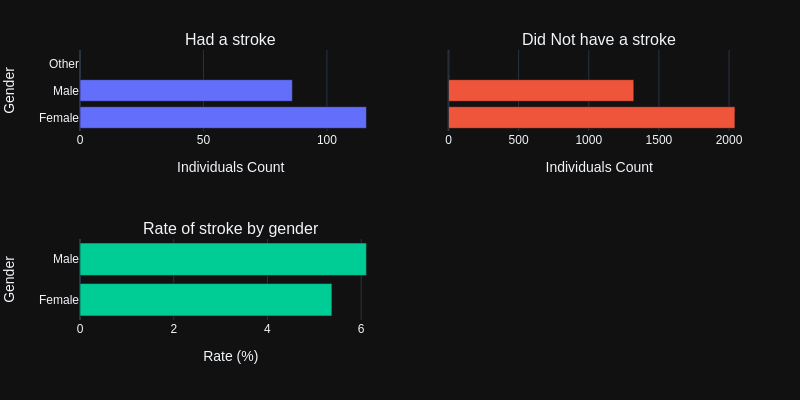

In [32]:
fig = make_subplots(rows=2, cols=2, shared_yaxes=True, vertical_spacing=0.4, horizontal_spacing=0.1, subplot_titles = ["Had a stroke", "Did Not have a stroke", "Rate of stroke by gender"])
fig.add_trace(go.Bar(x=stroke_gender_1['count(stroke)'], y=stroke_gender_1['Gender'], orientation='h'), row=1, col=1)
fig.add_trace(go.Bar(x=stroke_gender_2['count(stroke)'], y=stroke_gender_2['Gender'], orientation='h'), row=1, col=2)
fig.add_trace(go.Bar(x = stroke_rate_gender.values, y=  stroke_rate_gender.index, orientation='h'), row=2, col=1)
fig.update_xaxes(title = 'Individuals Count', row=1, col=1).update_xaxes(title = 'Individuals Count', row=1, col=2).update_xaxes(title = 'Rate (%)', row=2, col=1).update_yaxes(title = 'Gender', row=2, col=1)
fig.update_layout(yaxis_title='Gender', height=400, width=800, template="plotly_dark", showlegend=False, margin=dict(t=50, r =50))
fig.show('png')


#Análise da coluna "avg_glucose_level"
Foi analisado o nível de glicose médio no sangue separando também por grupos de gênero.
Os homens apresentaram uma média maior que das mulheres.

In [33]:
spark.sql('SELECT gender, avg(avg_glucose_level) FROM dataView GROUP BY gender').show()

+------+----------------------+
|gender|avg(avg_glucose_level)|
+------+----------------------+
|Female|     106.3854772937906|
| Other|                143.33|
|  Male|    112.94005685856435|
+------+----------------------+



Foi necessário verificar essa informação estatisticamente. Para escolhermos o teste adequado, primeiro foi preciso realizar um teste de normalidade para avaliar a distribuição da variável "avg_glucose_level". O resultado estatístico indicou que a hipótese nula de normalidade foi rejeitada, o que significa que com 99% de confiança, não podemos afirmar que essa variável segue uma distribuição normal.

In [34]:
from scipy.stats import kstest
from scipy.stats import mannwhitneyu

In [35]:
def normal_test(array, alpha):
  stat_test, p_value = kstest(array, 'norm')
  alpha = 0.01
  if p_value < alpha:  
      print("The null hypothesis can be rejected. It's not a normal distribution")
  else:
      print("The null hypothesis cannot be rejected. It's a normal distribution")


In [36]:
normal_test(data_modi.select('avg_glucose_level').toPandas(), alpha = 0.01)

The null hypothesis can be rejected. It's not a normal distribution


Foram criados DataFrames do Pandas separando os dados de glicose médio por gênero:

In [37]:
glucose_male = spark.sql('SELECT avg_glucose_level from dataView where gender == "Male"').toPandas()
glucose_female = spark.sql('SELECT avg_glucose_level from dataView where gender == "Female"').toPandas()

Como se trata de uma distruição não normal, foi escolhido o teste não paramétrico de média para amostras independentes Mann Whitneyu da biblioteca Scipy, utilizando o teste de calda superior.

### $H_0: \mu_{GB} = \mu_{RF}$

### $H_1: \mu_{GB} > \mu_{RF}$

In [38]:
def test_mean(array1, array2, alternative, alpha):
  U1, p_value = mannwhitneyu(glucose_male, glucose_female, alternative ="greater")
  if p_value < alpha:
      print("The null hypothesis can be rejected. The means are not igual.")
  else:
      print("The null hypothesis cannot be rejected. The means are igual.")

In [39]:
test_mean(glucose_male, glucose_female, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Podemos afirmar estatisticamente com 99% de confiança que os homens dessa amostra tem em média uma glicose média maior.

Foi feito também um teste de hipótese de média para testar se a média de glicose de quem já teve infarto é maior de quem já teve.

In [40]:
spark.sql('SELECT avg(avg_glucose_level) as avg_glucose_level_had_stroke from dataView where stroke == 1').show()

+----------------------------+
|avg_glucose_level_had_stroke|
+----------------------------+
|          134.34465346534648|
+----------------------------+



In [41]:
spark.sql('SELECT avg(avg_glucose_level) as avg_glucose_level_had_stroke from dataView where stroke == 0').show()

+----------------------------+
|avg_glucose_level_had_stroke|
+----------------------------+
|          107.45904577883448|
+----------------------------+



In [42]:
glucose_level_stroke1= spark.sql('SELECT avg_glucose_level from dataView where stroke == 1').toPandas()
glucose_level_stroke0= spark.sql('SELECT avg_glucose_level from dataView where stroke == 0').toPandas()

Foi aplicado novamente o teste Mann Whitneyu de média.

In [43]:
test_mean(glucose_level_stroke1, glucose_level_stroke0, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Com 99% de confiança, pode-se afirmar que as pessoas que tiveram AVC tem em média uma taxa de glicose média maior.

##Análise da variável "smoking_status"
A análise dessa variável foi feita em relação à variável dependente "stroke" para analisar a possível influência dessa variável nos derrames.

In [44]:
smoking_stroke_1 = spark.sql('SELECT smoking_status, COUNT(*) AS count_stroke_1, ROUND(COUNT(*)/(SELECT COUNT(*) FROM dataView WHERE stroke = 1)*100, 2) AS proportion_stroke_1 FROM dataView WHERE stroke = 1 GROUP BY smoking_status').toPandas()


In [45]:
smoking_stroke_1

,smoking_status,count_stroke_1,proportion_stroke_1
0,smokes,42,20.79
1,never smoked,90,44.55
2,formerly smoked,70,34.65


In [46]:
smoking_stroke_0 = spark.sql('SELECT smoking_status, COUNT(*) AS count_stroke_0, ROUND(COUNT(*)/(SELECT COUNT(*) FROM dataView WHERE stroke = 0)*100, 2) AS proportion_stroke_0 FROM dataView WHERE stroke = 0 GROUP BY smoking_status').toPandas()


In [47]:
smoking_stroke_0

,smoking_status,count_stroke_0,proportion_stroke_0
0,smokes,747,22.21
1,never smoked,1802,53.57
2,formerly smoked,815,24.23


Ao analisar o gráfico abaixo, é possível observar uma diferença considerável na taxa de indivíduos que nunca fumaram e fumam socialmente entre os grupos que tiveram e não tiveram AVC.

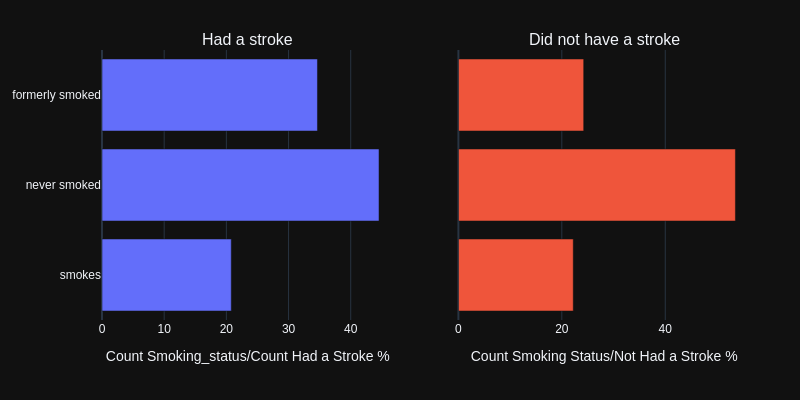

In [48]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, vertical_spacing=0.4, horizontal_spacing=0.1, subplot_titles = ["Had a stroke", "Did not have a stroke"])
fig.add_trace(go.Bar(x=smoking_stroke_1.proportion_stroke_1, y=smoking_stroke_1.smoking_status, orientation='h', name="Ataque Cardíaco"), row=1, col=1)
fig.add_trace(go.Bar(x=smoking_stroke_0.proportion_stroke_0, y=smoking_stroke_0.smoking_status, orientation='h', name="Ataque Cardíaco"), row=1, col=2)

fig.update_xaxes(title = "Count Smoking_status/Count Had a Stroke %", row=1, col=1).update_xaxes(title = "Count Smoking Status/Not Had a Stroke %", row=1, col=2)
fig.update_layout(height=400, width=800, template="plotly_dark", showlegend=False, margin=dict(t=50, r =50))
fig.show('png')

#Análise da variável "age":


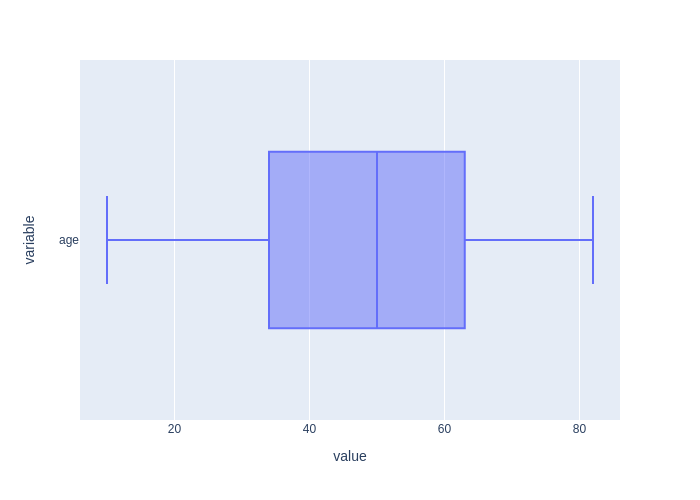

In [49]:
fig = px.box(df.age, orientation= 'h')
fig.show('png')

In [50]:
spark.sql('SELECT age from dataView').summary().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              3566|
|   mean| 48.85389792484577|
| stddev|18.874375282520642|
|    min|              10.0|
|    25%|              34.0|
|    50%|              50.0|
|    75%|              63.0|
|    max|              82.0|
+-------+------------------+



In [51]:
spark.sql('SELECT avg(age) from dataView where stroke == 1').show()

+-----------------+
|         avg(age)|
+-----------------+
|68.16831683168317|
+-----------------+



In [52]:
spark.sql('SELECT avg(age) from dataView where stroke == 0').show()

+------------------+
|          avg(age)|
+------------------+
|47.694114149821644|
+------------------+



In [53]:
normal_test(df.age, alpha = 0.01)

The null hypothesis can be rejected. It's not a normal distribution


In [54]:
age_stroke1 = spark.sql('SELECT age from dataView where stroke == 1').toPandas()
age_stroke0 = spark.sql('SELECT age from dataView where stroke == 0').toPandas()

In [55]:
test_mean(age_stroke1, age_stroke0, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Podemos afimar com 99% de confiança que as pessoas da amostra que sofreram derrame em média mais velhas com idade e média superior a 40% (68/47).